In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("seaborn-notebook")

# Deterministic gravity inversion using gradient descent

Based on measurements of changes in gravitational acceleration, one can infer distributions of density within the Earth. This is useful for geothermal exploration (i.e., to study fault systems or identify a positive geothermal anomaly due to a volcanic host rock) and it represents an inverse problem, which we will solve here in a determinstic fashion. We start by loading and looking at the data.

<AxesSubplot:xlabel='x (m)'>

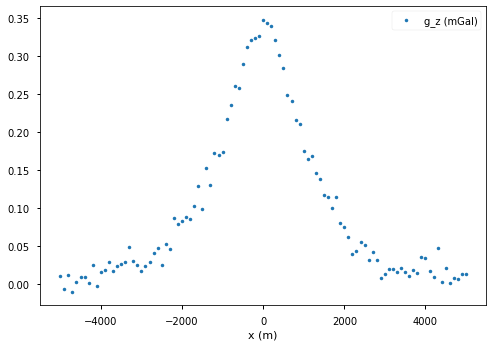

In [2]:
data = pd.read_csv("data/grav.csv", index_col=0)
data.plot(style=".")

In [3]:
data.head()

,g_z (mGal)
x (m),
-5000.0,0.011387
-4900.0,-0.006838
-4800.0,0.011793
-4700.0,-0.009910
-4600.0,0.002598


In [4]:
x = data.index.values
gz = data.values.flatten()

## The forward problem

As the forward problem, we will be using an analytical expression for a spheric anomaly in the subsurface given by:

$$
\Delta\mathrm{g}_{\mathrm{z}}=\mathrm{G} \frac{4}{3} \pi \mathrm{R}^{3} \Delta \rho \frac{\mathrm{z}}{\left(\mathrm{x}^{2}+\mathrm{z}^{2}\right)^{3 / 2}}
$$

where $\Delta\mathrm{g}_{\mathrm{z}}$ is the vertical component of the gravimetric anomaly in m/s$^2$, $G$ is the gravitational constant (6.6743 $\times 10^{-11}$ m$^3$/(kg $\times$ s$^2$)), $R$ is the radius of the sphere in meter, $\Delta \rho$ is the density contrast between the anomaly and the surrounding rock in kg/m$^3$, $z$ is the depth of the center of the sphere, and $x$ is the location along the profile.
Both $x$ and $z$ are in meters.

We can put this formula into a Python function:

In [5]:
G = 6.6743e-11 # gravitational constant

def grav(R, z, density=1000):
    """Formula from the exercise sheet as a function for later reuse."""
    gz = 4/3 * np.pi * R**3 * density * G * z / (x**2 + z**2)**(3/2)
    gz *= 1e5 # unit conversion from SI to mGal
    return gz

## The well-posed inverse problem

Let's assume that we know from geological a priori information that the density contrast between the sandstones and the volcanic target is 1000 kg/m^3. This means, we only have to estimate the depth and the radius of the spherical anomaly. A first approach for inversion, would just be trying out different parameters. This is called the grid search procedure (or "brute force approach").

Given a set of realistic parameter ranges, the [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) function can create two grids in matrix form that reflect the possible parameter combinations. This is useful to determine the corresponding parameters once you have found an optimum. 

To find an optimum you also need to create an objective function that returns the norm of the prediction error, as well as an appropriately shaped array to store the objective function evaluations. The [argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html?highlight=argmin#numpy.argmin) function helps you find the index of the optimum.

To loop over a set of items while also getting their indices returned, use the [enumerate](https://www.programiz.com/python-programming/methods/built-in/enumerate) function.

In [6]:
density = 1000

size=250
radii = np.linspace(50,500,size)
depth = np.linspace(500,3000,size)

obj = np.zeros((size, size))
X, Y = np.meshgrid(radii, depth)

def objective(R, z):
    return np.linalg.norm(gz - grav(R, z, density))
    
for i, R in enumerate(radii):
    for j, z in enumerate(depth):
        obj[j, i] = objective(R, z)
 
i, j = np.where(obj == obj.min())
rad_opt, depth_opt = X[i,j],Y[i,j]

plt.plot(rad_opt, depth_opt, "ro")### Visualizing the prediction error for all combinations of R and z

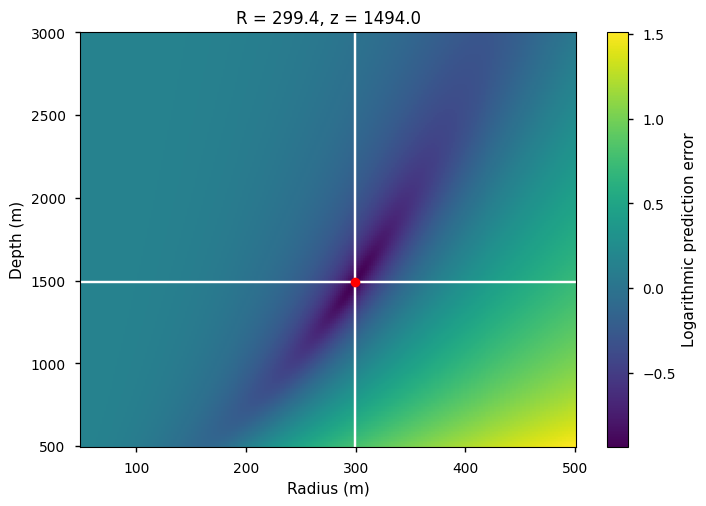

In [7]:
plt.figure(dpi=100)
plt.pcolor(X, Y, np.log10(obj))
plt.axvline(rad_opt, color="w")
plt.axhline(depth_opt, color="w")
plt.plot(rad_opt, depth_opt, "ro")
plt.title("R = %.1f, z = %.1f" % (rad_opt, depth_opt))
plt.xlabel("Radius (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label="Logarithmic prediction error")

While this worked well and was relatively easy to implement (two for loops looping over the two parameters), it can be computationally prohibitive for real-work problems with hundreds or thousands of parameters and with a more complex forward problem (i.e., 3D simulation code rather than analytical formula). Today, we want to try a different, smarter approach.

# Gradient descent

As opposed to the global grid-search optimization shown above, [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is a local optimization scheme. This approach, or variants of it, are commonly used in non-linear geophysical inversion, but also in other areas such as the training of neural networks. The main advantage of this method, as opposed to a grid-search, is that it usually requires much fewer executions of the forward function/model, thereby significantly improving it's efficiency. That is because only a small subset of the model space is explored.

The iterative algorithm starts with an initial guess, the starting model. In each iteration step, the gradient of the objective function in each dimension (i.e., with respect to each model parameter) is calculated. Since analytical solutions to this are often unavailable, this is commonly achieved by finite-difference calculations, meaning that the model is slightly varied and we check how the resonse changes. This gradient indicates in which way the model parameters should change in order to decrease the objective function. The exact amount by which the parameters are modified in each step is determined by a step length parameter. This iterative process is repeated until the objective function does not notably change anymore or the number of maximum iterations it reached.

Note that this scheme can be quite dependent on the initial model: If there are several minima to the objective function, gradient descent will converge towards the one closest to the starting model.

Start by defining a central finite-difference approximation of the objective function's gradient (see the section on [relation with derivatives here](https://en.wikipedia.org/wiki/Finite_difference)) with respect to both model parameters (return a value for each!). The perturbation parameter $h$ should not change throughout the inversion and can be set to 0.1. Note that our objective function is a multi-variate function, meaning that it has two parameters (radius and depth). The gradient you need is:

$$\nabla \Psi(r,z) = \left[\frac{\partial}{\partial r} \Psi, \frac{\partial}{\partial z} \Psi\right]$$

Define a function that calculates the gradient (with central finite-differences) and returns it as a numpy array at a given pair of $r$ and $z$.

In [8]:
# Finite-difference approximation of the gradient
def gradient(x, y):
    h = .1
    grad_x = (objective(x + h, y) - objective(x - h, y))/(2*h)
    grad_y = (objective(x, y + h) - objective(x, y - h))/(2*h)
    return np.array([grad_x, grad_y])

Define a starting model with a radius of 25 m and a depth of 40 m. Calculate the gradient at this position. It should be approximately [0.06, -0.02].

In [9]:
start = [25, 40]
gradient(*start)

array([-0.00275863,  0.00061308])

Now you can implement the gradient descent. Define a starting model $m_0$, step-length $\alpha$ and the desired precision threshold. Model updates are calculated by multiplying the negative step length with the gradient. The procedure is as follows:

1. Current model equals starting model $m = m_0$

2. Calculate model update based on negative gradient $\Delta m = -\alpha \nabla\Psi(m)$

3. Update model $m = m + \Delta m$

4. Repeat from step 2

Start with a step length of $\alpha = 20$ and a maximum number of 1000 iterations. Visualize the current model estimate of each iteration on top of the figures of the grid search (as a simple point with `plt.plot`. Does your algorithm walk into the right direction? Does it reach the minimum?

Final iteration # 5000 : Model vector is [ 299.89582273 1496.10219448]


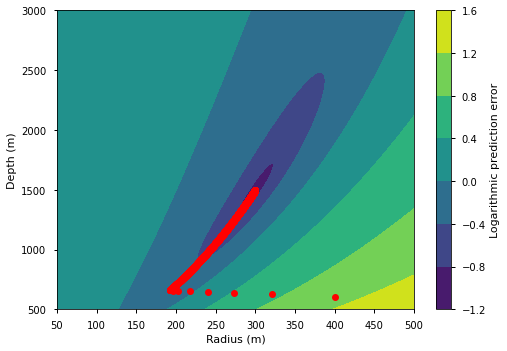

In [10]:
m_current = np.array([400.0,600.0]) # starting model
alpha = 800 # step length 
precision = 0.1 # When to stop?
delta_m = np.array([1., 1.])
max_iters = 5000 # maximum number of iterations
it = 0 # iteration counter
error = precision + 1

iterations = []
errors = []

fig, ax = plt.subplots()
im = ax.contourf(X, Y, np.log10(obj))

while error > precision and it < max_iters:
    ax.plot(m_current[0], m_current[1], "ro")
    iterations.append(it)
    
    delta_m = -alpha * gradient(*m_current)

    m_current += delta_m # Grad descent
    
    error = np.linalg.norm(gz - grav(m_current[0], m_current[1]))
    errors.append(error)
        
    it += 1 # iteration count

rad_opt, depth_opt = m_current

ax.plot(rad_opt, depth_opt, "gx")
ax.set_xlabel("Radius (m)")
ax.set_ylabel("Depth (m)")
fig.colorbar(im, label="Logarithmic prediction error")

print("Final iteration #", it,": Model vector is", m_current)

Visualize the convergence by plotting your error (`np.linalg.norm(dobs - grav(r_k, z_k))` history against the iteration number $k$.

Text(0, 0.5, 'Logarithmized prediction error')

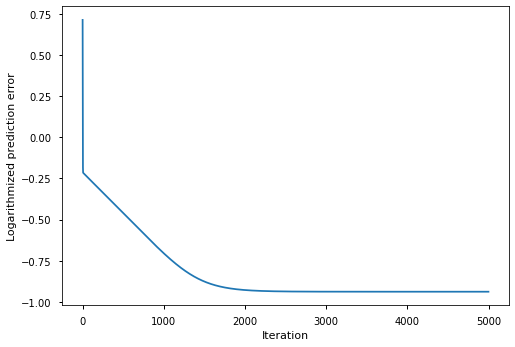

In [14]:
plt.plot(iterations, np.log10(errors))
plt.xlabel('Iteration')
plt.ylabel('Logarithmized prediction error')

Play with the step size $\alpha$. What is its effect?

## The ill-posed inverse problem

Now let's assume we do not know the density beforehand, but we have an estimate of the depth.

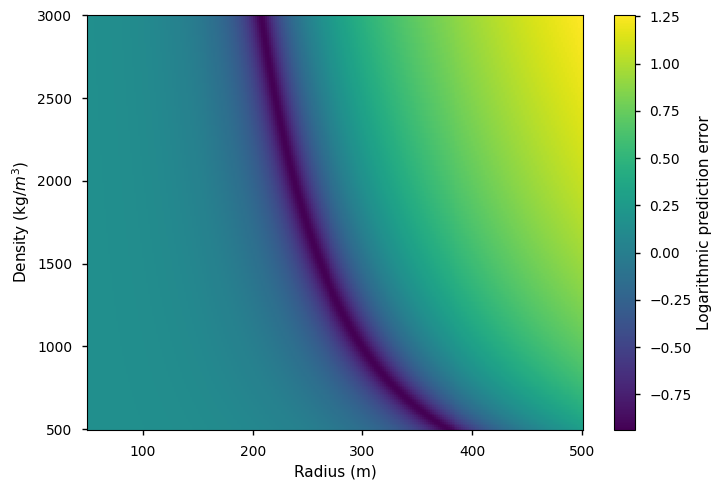

In [12]:
correct_depth = 1500

size=250
radii = np.linspace(50,500,size)
densities = np.linspace(500,3000,size)

obj = np.zeros((size, size))
X, Y = np.meshgrid(radii, densities)

def objective(R, rho):
    return np.linalg.norm(gz - grav(R, correct_depth, rho))
    
for i, R in enumerate(radii):
    for j, rho in enumerate(densities):
        obj[j, i] = objective(R, rho)
 
plt.figure(dpi=100)
plt.pcolor(X, Y, np.log10(obj))
plt.xlabel("Radius (m)")
plt.ylabel("Density (kg/$m^3$)")
plt.colorbar(label="Logarithmic prediction error")